In [1]:
from __future__ import division, print_function, absolute_import
import os, sys, time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
from PIL import Image
from scipy.io import loadmat
import math
import pickle
import glob
import csv

In [ ]:
#-------------------------------------------------------------------------------
import tflearn
from tflearn.data_utils import shuffle
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
#-------------------------------------------------------------------------------

In [2]:
def load_data():
        labels = []
        filenames = []
        with open('./grocery_data.labels.txt') as f:
                r = csv.reader(f)
                for row in r:
                        labels.append(int(row[1]))
                        filenames.append(row[0])
        return labels,filenames

In [ ]:
def create_pickle(labels_orig, filenames, n_epoch, n_classes, image_size, conv_pass, logfile):
    dirname = '/data/shared/images/grocerystore/'

    print('resizing images')
    num = len(labels_orig)
    sz = int(image_size)
    rids = np.random.permutation(len(filenames))[0:num]
    data = np.zeros([num,sz,sz,3])
    labels = np.zeros([num,n_classes])

    for i in range(num):
        sampleid = rids[i]                  #error fix 0 image
        fname = dirname+filenames[sampleid]
        #print(fname)
        img = Image.open(fname)
        img1 = img.resize([sz,sz])
        imgarr = np.array(img1.getdata()).reshape(img1.size[0], img1.size[1], 3)
        data[i,:,:,:] = imgarr
        labels[i,labels_orig[sampleid]-1] = 1           # possible eror here

    print('splitting into training and test data')
    #split data into train and test (cast to int)
    spl = int(math.floor(num/2))
    X = data[0:spl,:,:,:]
    X_test = data[spl:,:,:,:]
    Y = labels[0:spl,:]
    Y_test = labels[spl:,:]

    print('pickling data')
    # save data
    pickle.dump(X,open('grocery_dataset_X.pkl','wb'))
    pickle.dump(Y,open('grocery_dataset_Y.pkl','wb'))
    pickle.dump(X_test,open('grocery_dataset_X_test.pkl','wb'))
    pickle.dump(Y_test,open('grocery_dataset_Y_test.pkl','wb'))

In [ ]:
def create_network(image_size):
    print('defining network architecture')
    # Make sure the data is normalized
    img_prep = ImagePreprocessing()
    img_prep.add_featurewise_zero_center()
    img_prep.add_featurewise_stdnorm()
    # Create extra synthetic training data by flipping, rotating and blurring the images
    img_aug = ImageAugmentation()
    img_aug.add_random_flip_leftright()
    img_aug.add_random_rotation(max_angle=25.)
    img_aug.add_random_blur(sigma_max=3.)
    # Define network architecture:Input is a 32x32 image with 3 color channels
    #network = input_data(shape=[None, 32, 32, 3],data_preprocessing=img_prep,data_augmentation=img_aug)
    network = input_data(shape=[None, image_size, image_size, 3],data_preprocessing=img_prep,data_augmentation=img_aug)
    #2 passes through convolution and pooling

    for j in range (1, (int(conv_pass)+1)):
        print('convolution and pooling sequence: ', str(j))
        # Step 1: Convolution
        network = conv_2d(network, 32, 3, activation='relu')
        # Step 2: Max pooling
        network = max_pool_2d(network, 2)
        # Step 3: Convolution again
        network = conv_2d(network, 64, 3, activation='relu')
        # Step 4: Convolution yet again
        network = conv_2d(network, 64, 3, activation='relu')
        # Step 5: Max pooling again
        network = max_pool_2d(network, 2)

    print('finished convolution and pooling' )

    # Step 6: Fully-connected 512 node neural network
    network = fully_connected(network, 512, activation='relu')
    # Step 7: Dropout - throw away some data randomly during training to prevent over-fitting
    network = dropout(network, 0.5)
    # Step 8: Fully-connected neural network with two outputs (0=isn't a grocery, 1=is a grocery) to make the final prediction
    network = fully_connected(network, 2, activation='softmax')
    # Tell tflearn how we want to train the network
    network = regression(network, optimizer='adam', loss='categorical_crossentropy',learning_rate=0.001)
    return network


In [ ]:
def test(labels_orig, filenames, n_epoch, n_classes, image_size, conv_pass, logfile):
    print()
    print('n_epochs: ', n_epoch)
    print('selected image size: ', image_size)
    print('number of convolution block passes: ', conv_pass)
    print()

    sz = int(image_size)
    print('loading data')
    X = pickle.load(open("grocery_dataset_X.pkl","rb"))
    X_test = pickle.load(open("grocery_dataset_X_test.pkl","rb"))
    Y = pickle.load(open("grocery_dataset_Y.pkl","rb"))
    Y_test = pickle.load(open("grocery_dataset_Y_test.pkl","rb"))

    print('image preparations')
    X_, Y_ = shuffle(X, Y)
    network = create_network(sz)
    print('wrapping network in a model')
    # Wrap the network in a model object
    model = tflearn.DNN(network, tensorboard_verbose=0, checkpoint_path='grocery-classifier.tfl.ckpt')
    # Train it! We'll do 100 training passes and monitor it as it goes.
    print('training with ' + str(n_epoch) + ' passes...') # batch_size was 96 for 32x32 image;  n*image size
    bs = 3*sz
    model.fit(X_, Y_, int(n_epoch), validation_set=(X_test, Y_test),show_metric=True, batch_size=bs)

    accuracy_score = model.evaluate(X_test, Y_test)
    accuracy = '... accuracy: %0.4f%%' % (accuracy_score[0] * 100)
    print(accuracy)
    print('saving results')
    message = 'feature #' + str(featurenum) + ': ' +selected[0] + ' ' + str(accuracy) +  ' with ' + str(n_epoch) + ' passes'
    logstatus(os.getcwd(), logfile, message, 'a')


In [ ]:
def logstatus(path, logfile, message, method):
    datafilepath = path+logfile
    tempfile = open(datafilepath, method)
    result = time.strftime("%d %b %Y %H:%M:%S") + " " + message + "\n"
    tempfile.write(result)
    tempfile.close()

In [ ]:
labels,filenames = load_data()

In [ ]:
logfile = '_CNN_32pix_10k_2convpass.txt'

#-------------------------------------------------------------------------------
#settings
n_epoch = 50                    #50, 100
image_size = 32                 #32, 64
conv_pass = 2                   #1, 2
n_classes = 5
#------------------------------------------------

In [ ]:
#create_pickle(labels, filenames, n_epoch, n_classes, image_size, conv_pass, logfile)
test(labels, filenames, n_epoch, n_classes, image_size, conv_pass, logfile)

In [ ]:
print()
print('n_epochs: ', n_epoch)
print('selected image size: ', image_size)
print('number of convolution block passes: ', conv_pass)
print()

sz = int(image_size)
print('loading data')
X = pickle.load(open("grocery_dataset_X.pkl","rb"))
X_test = pickle.load(open("grocery_dataset_X_test.pkl","rb"))
Y = pickle.load(open("grocery_dataset_Y.pkl","rb"))
Y_test = pickle.load(open("grocery_dataset_Y_test.pkl","rb"))

print('image preparations')
X, Y = shuffle(X, Y)
network = create_network(sz)
print('wrapping network in a model')
# Wrap the network in a model object
model = tflearn.DNN(network, tensorboard_verbose=0, checkpoint_path='grocery-classifier.tfl.ckpt')
# Train it! We'll do 100 training passes and monitor it as it goes.
print('training with ' + str(n_epoch) + ' passes...') # batch_size was 96 for 32x32 image;  n*image size
bs = 3*sz


In [ ]:
model.fit(X, Y, int(n_epoch), validation_set=(X_test, Y_test),show_metric=True, batch_size=bs)

In [ ]:
accuracy_score = model.evaluate(X_test, Y_test)
accuracy = '... accuracy: %0.4f%%' % (accuracy_score[0] * 100)
print(accuracy)
print('saving results')
message = 'feature #' + str(featurenum) + ': ' +selected[0] + ' ' + str(accuracy) +  ' with ' + str(n_epoch) + ' passes'
logstatus(os.getcwd(), logfile, message, 'a')

In [55]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [ ]:
_X = [X]

In [ ]:
for i,x in enumerate(_X):
    print(i)

In [4]:
X = pickle.load(open("grocery_dataset_X.pkl","rb"),encoding='latin1')
X_test = pickle.load(open("grocery_dataset_X_test.pkl","rb"),encoding='latin1')
Y = pickle.load(open("grocery_dataset_Y.pkl","rb"),encoding='latin1')
Y_test = pickle.load(open("grocery_dataset_Y_test.pkl","rb"),encoding='latin1')

In [24]:
X1 = np.zeros([8470,32*32*3])
Y1 = np.zeros([8470,])
X1_test = np.zeros([8470,32*32*3])
Y1_test = np.zeros([8470,])

In [25]:
for i in range(8470):
    X1[i,:] = X[i,:,:,:].flatten()
    Y1[i] = np.where(Y[i,:] == 1)[0]    
    X1_test[i,:] = X_test[i,:,:,:].flatten()
    Y1_test[i] = np.where(Y_test[i,:] == 1)[0]

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
mdl = LogisticRegression()
mdl.fit(X1,Y1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
Y1_pred = mdl.predict(X1_test)

In [31]:
from sklearn.metrics import confusion_matrix

In [35]:
cmat = confusion_matrix(Y1_test,Y1_pred)

In [60]:
cmat

array([[1785,    0,    0,    0,    0],
       [   0, 2024,    9,    7,    4],
       [   0,    4, 1818,    0,    0],
       [   1,    6,    1, 1589,    1],
       [   0,    0,    5,    0, 1216]])

In [43]:
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

In [52]:
pmdl = PCA(n_components=3)
#pmdl = Isomap(n_components=2)

In [53]:
pmdl.fit(X1)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [54]:
X1_reduced = pmdl.transform(X1)

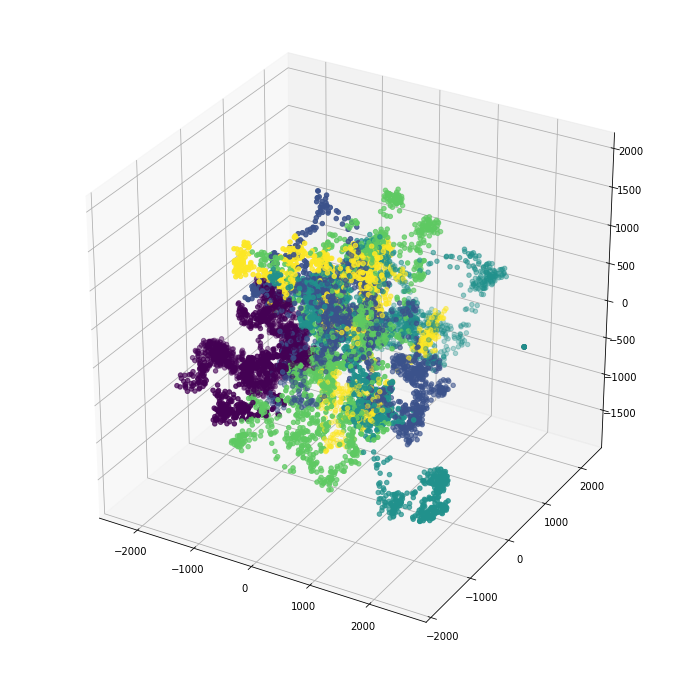

In [59]:
fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1_reduced[:,0],X1_reduced[:,1],X1_reduced[:,2],c=Y1)

In [82]:
labels = ['cereals','cleaning','beverages','chips+snacks','cannedgoods']

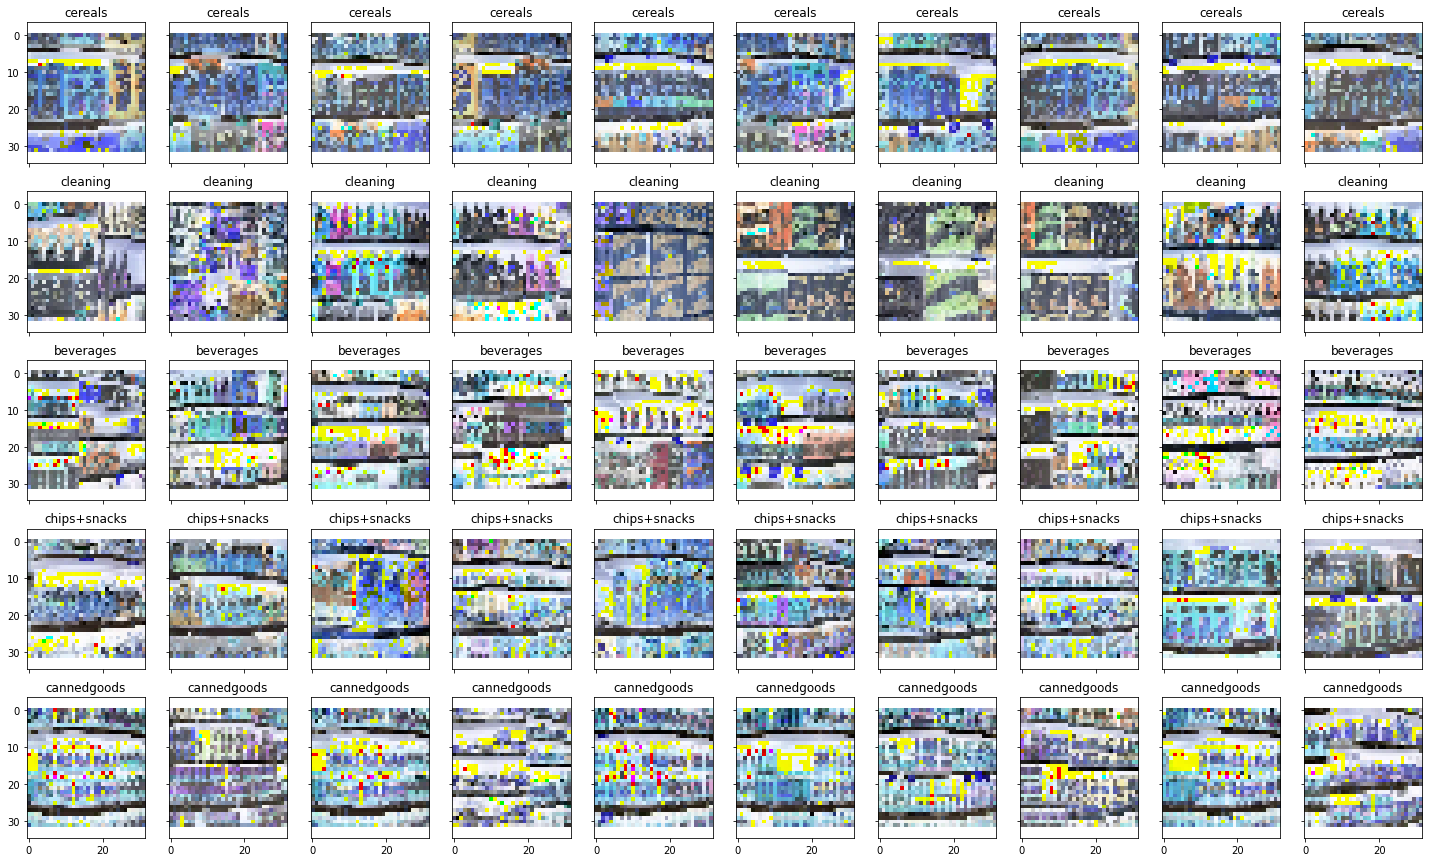

In [85]:
fig, ax = plt.subplots(5, 10, sharex='col', sharey='row',figsize=[25,15])
for i in range(5):
    inds = np.where(Y1 == i)[0]
    rinds = np.random.permutation(len(inds))[0:10]
    for j in range(10):
        ax[i,j].imshow(X[inds[rinds[j]],:,:])
        ax[i,j].set_title(labels[i])